# Exercise 03
## Lars Kühmichel, Nicolas Wolf

In [60]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import scipy.stats as scistats

In [61]:
plt.rc("figure", dpi=150)
plt.rc("legend", fontsize=6)

## Task 1: Univariate AR Models

Consider the time series `DLPFC`

As always, load and inspect the data:

In [62]:
df = pd.read_csv("data/ex3file1.csv")

In [63]:
df.head()

,DLPFC,DLPFC.1,Parietal,Parietal.1
0,2.28550,-0.29516,-3.0362,-4.51840
1,0.85457,-2.63380,-4.5223,-1.90250
2,-0.26151,-3.08110,-4.7146,0.47887
3,-1.19410,-2.62330,-3.9754,1.92820
4,-1.27900,-1.61420,-2.0104,3.77230


<AxesSubplot:>

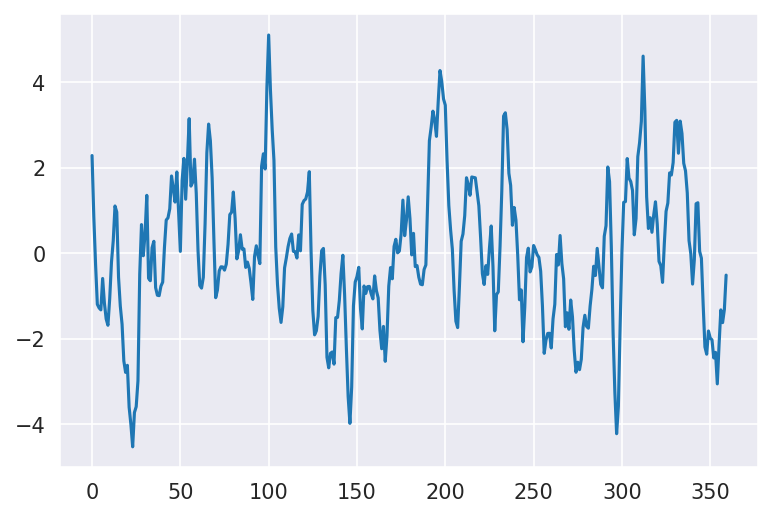

In [64]:
df["DLPFC"].plot()

### 1. Compute the log-likelihood of an AR(4) model. Please write down explicitly.

According to the script, the log-likelihood is given as:

$$
\log L(\{ \alpha_i \}, \sigma) = - \frac{T-p}{2} \log (2 \pi) - \frac{T-p}{2} \log(\sigma^2) - \frac{1}{2} \bold{\varepsilon}^T \bold{\varepsilon} \sigma^{-2}
$$

where $\{ \alpha_i \}$ is the set of model coefficients, $\sigma$ is the standard deviation of the process noise $\bold{\varepsilon} \sim \mathcal{N}(0, \sigma^2 \bold{I})$, $T$ is the length of the time series, and $p$ is the order of the AR process.


In [65]:
model = sm.tsa.AutoReg(endog=df["DLPFC"], lags=4, trend="n")
result = model.fit()

p = 4
T = len(df)
sigma = np.sqrt(result.sigma2)
epsilon = result.resid
ll = -0.5 * (T - p) * np.log(2 * np.pi) - 0.5 * (T - p) * np.log(sigma ** 2) - 0.5 * np.dot(epsilon, epsilon) * sigma ** (-2)
llf = result.llf

print(f"Library: {llf:.2f}")
print(f"Ours:    {ll:.2f}")
print(f"Close?   {np.isclose(llf, ll)}")

Library: -365.77
Ours:    -365.77
Close?   True


The log-likelihood is quite small. However, the model yields a good fit:

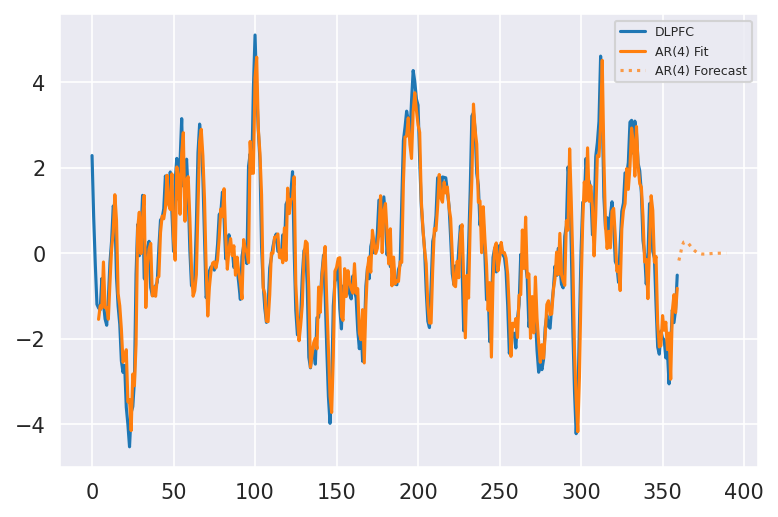

In [66]:
df["DLPFC"].plot()
sns.lineplot(x=df.index, y=result.predict(), label="AR(4) Fit")
result.forecast(steps=30).plot(color="C1", ls=":", alpha=0.75, label="AR(4) Forecast")
plt.legend()

### 2. Plot the residuals of the model in a histogram. What do they look like? What do you expect?

The model still deviates from the true signal especially at the peaks. Thus, we would expect significant residuals in those areas. Residuals should look like the multivariate normal noise $\bold{\varepsilon}$, which we confirm with the histogram and an overlaid distribution kde plot. Notably, the residuals are not time-dependent.

Text(0.5, 1.0, 'Residuals')

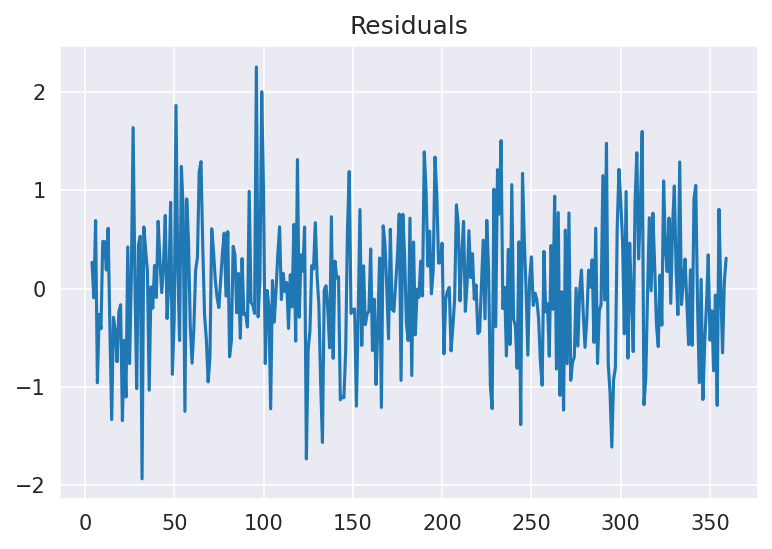

In [67]:
residuals = df["DLPFC"] - result.predict()
sns.lineplot(x=df.index[model.hold_back:], y=result.resid)
plt.title("Residuals")

/home/lars/code/python/TSA-RNN/.venv/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


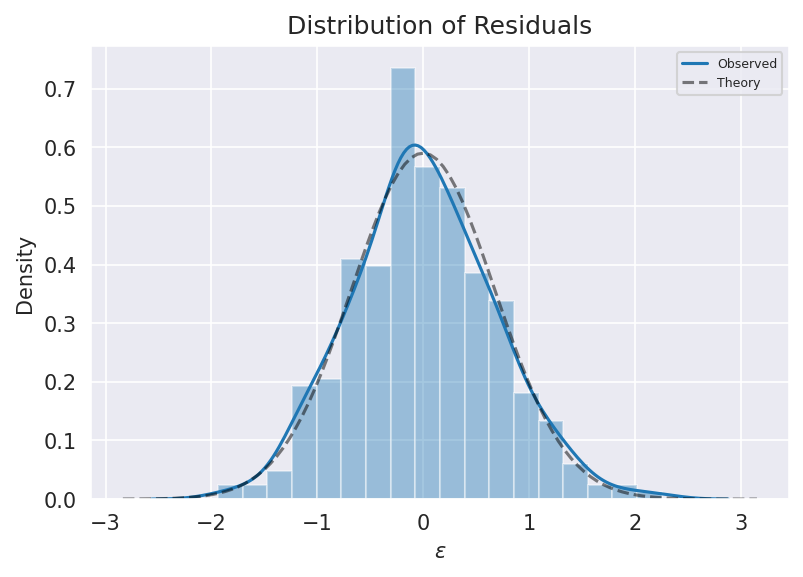

In [68]:
sns.distplot(residuals, kde_kws=dict(label="Observed"))
x = np.linspace(*plt.xlim(), num=100)
y = scistats.norm.pdf(x, scale=sigma)
plt.plot(x, y, ls="--", alpha=0.5, color="black", label="Theory")
plt.xlabel(r"$\varepsilon$")
plt.title("Distribution of Residuals")
plt.legend()

### 3. Compute the log-likelihood of an AR($n$) model, with $n$ ranging from $1...5$.

We compute it from $1...100$:

<AxesSubplot:>

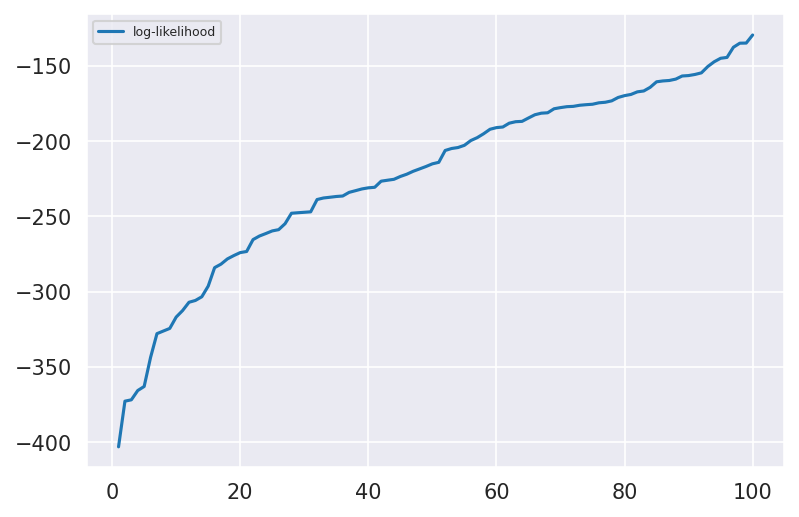

In [69]:
ns = np.arange(start=1, stop=100 + 1)

results = []
lls = []

for n in ns:
    model = sm.tsa.AutoReg(endog=df["DLPFC"], lags=n, trend="n")
    result = model.fit()
    results.append(result)
    lls.append(result.llf)

likelihoods = pd.DataFrame({"log-likelihood": lls}, index=ns)

likelihoods.plot()

### How does the likelihood change when you increase the order of the model?

The log-likelihood increases as the number of parameters increases. This means the model will more accurately capture the training set, which is logical since the model gains explanatory power. However, a large number of parameters will lead to overfitting.

### 4. Bonus Exercise: Increasing the capacity of the model is likely to increase its explanatory power, but it is important to explore the tradeoff between this and the increase in model parameters. Determine the optimal order $p$ of the AR model by computing the log-likelihood ratio test statistic.

The p-value for the likelihood-ratio-test gives the probability that the hypothesis "The unrestricted model improves on the restricted one" is false. The optimal order is thus that of the restricted model at the first (desired) maximum of p.

In [70]:
from statsmodels.base.model import LikelihoodModelResults as LMR


def lr_test(restricted: LMR, unrestricted: LMR) -> float:
    """ Perform a Likelihood-Ratio-Test between a restricted and unrestricted model """
    # determine the appropriate degrees of freedom
    dof = restricted.df_resid - unrestricted.df_resid
    # likelihood-ratio-test-statistic or "D" on the sheet:
    stat_lr = -2 * (restricted.llf - unrestricted.llf)
    # perform chi-squared test (compute p-value)
    return scistats.chi2.sf(stat_lr, df=dof)

The optimal order is 2. An argument could also be made for 20, 30, 63, 71 and 98 since these have even higher p-values, depending on the statistical certainty requirement. Orders 28, 29 and 30 also stand out because they successively yield good p-values.

Marked Peaks are at: [2, 20, 28, 29, 30, 63, 71, 98]


Text(0.5, 1.0, 'Likelihood-Ratio-Test Results')

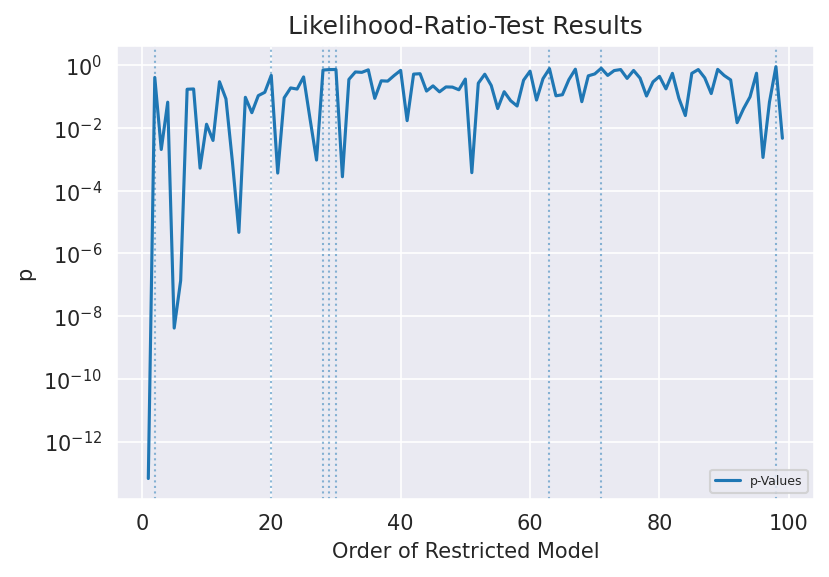

In [71]:
ps = []

for restricted, full in zip(results[:-1], results[1:]):
    ps.append(lr_test(restricted, full))

peaks = []
m = ps[0]
for i, p in enumerate(ps):
    if p > m:
        m = p
        peaks.append(i + 1)


sns.lineplot(x=ns[:-1], y=ps, label="p-Values")
print(f"Marked Peaks are at: {peaks}")
for p in peaks:
    plt.axvline(p, ls=":", lw=1, alpha=0.5)

plt.xlabel("Order of Restricted Model")
plt.ylabel("p")
plt.yscale("log")
plt.legend(loc="lower right")
plt.title("Likelihood-Ratio-Test Results")

## Task 2: Multivariate (vector) AR (=VAR) processes

Now use all four time series `DLPFC1, DLPFC2, Parietal1, Parietal2`.

<AxesSubplot:>

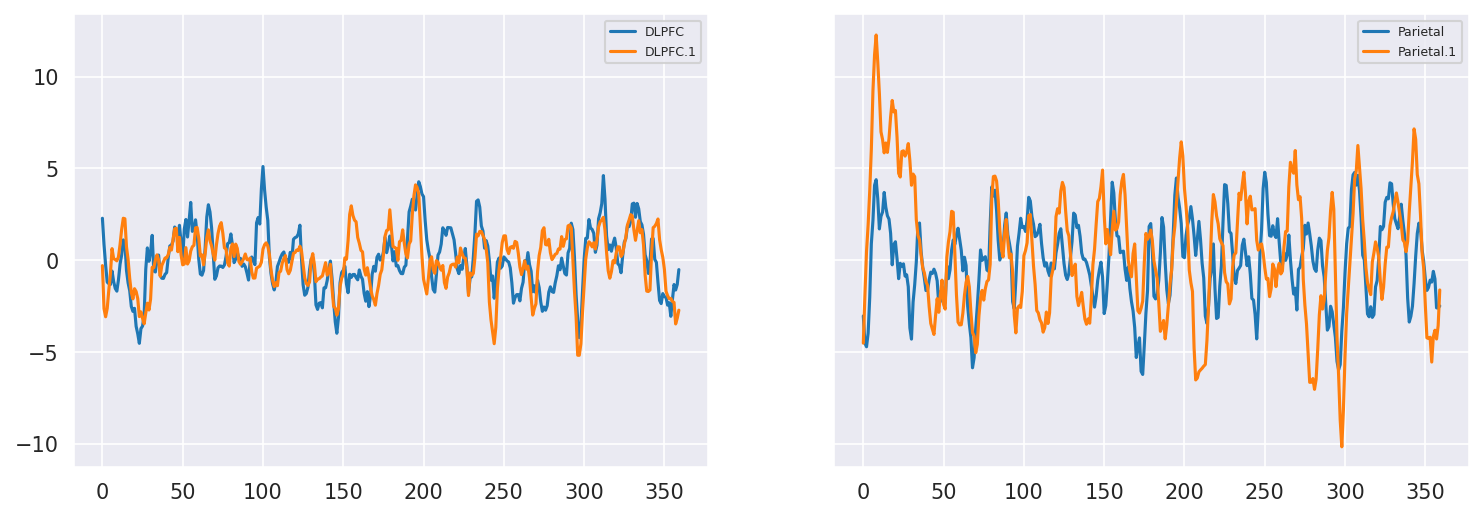

In [72]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex="all", sharey="all")
df[["DLPFC", "DLPFC.1"]].plot(ax=axes[0])
df[["Parietal", "Parietal.1"]].plot(ax=axes[1])


### 1. Estimate a VAR(1) model by performing multivariate regression on the 4-variate time series.

In [73]:
model = sm.tsa.VAR(df)
result = model.fit()

print(result.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 16, May, 2022
Time:                     00:53:53
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -1.53904
Nobs:                     359.000    HQIC:                  -1.66935
Log likelihood:          -1702.51    FPE:                   0.172843
AIC:                     -1.75538    Det(Omega_mle):        0.163540
--------------------------------------------------------------------
Results for equation DLPFC
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.002490         0.039307            0.063           0.949
L1.DLPFC              0.906687         0.028281           32.060           0.000
L1.DLPFC.1           -0.020353         0.036711           -0

### What do the coefficients in matrix $A$ tell you about the coupling between the DLPFC and parietal cortex?

The `DLPFC` and `Parietal` series are weakly coupled, since the coupling coefficients are `0.016` and `-0.012` respectively. We can also reason that the absolute influence `DLPFC` has on `Parietal` is around the same strength as the other way around, i.e. neither is particularly causative of the other. The strongest (non-self) coupling exists from `Parietal.1` to `DLPFC`, with a coefficient of `0.154`.

In [74]:
names = ["DLPFC", "DLPFC.1", "Parietal", "Parietal.1"]
A = pd.DataFrame(data=np.squeeze(result.coefs), index=names, columns=names)
A

,DLPFC,DLPFC.1,Parietal,Parietal.1
DLPFC,0.906687,-0.020353,0.015690,-0.033757
DLPFC.1,0.009752,0.898532,-0.005184,-0.007244
Parietal,-0.012232,0.045263,0.872665,0.001585
Parietal.1,0.153981,-0.097981,0.014444,0.936341


### Is the resulting VAR(1) model stationary or not?

We would expect the model to be stationary, since the underlying time series were stationary. Since the model fits well, this is a reasonable assumption.

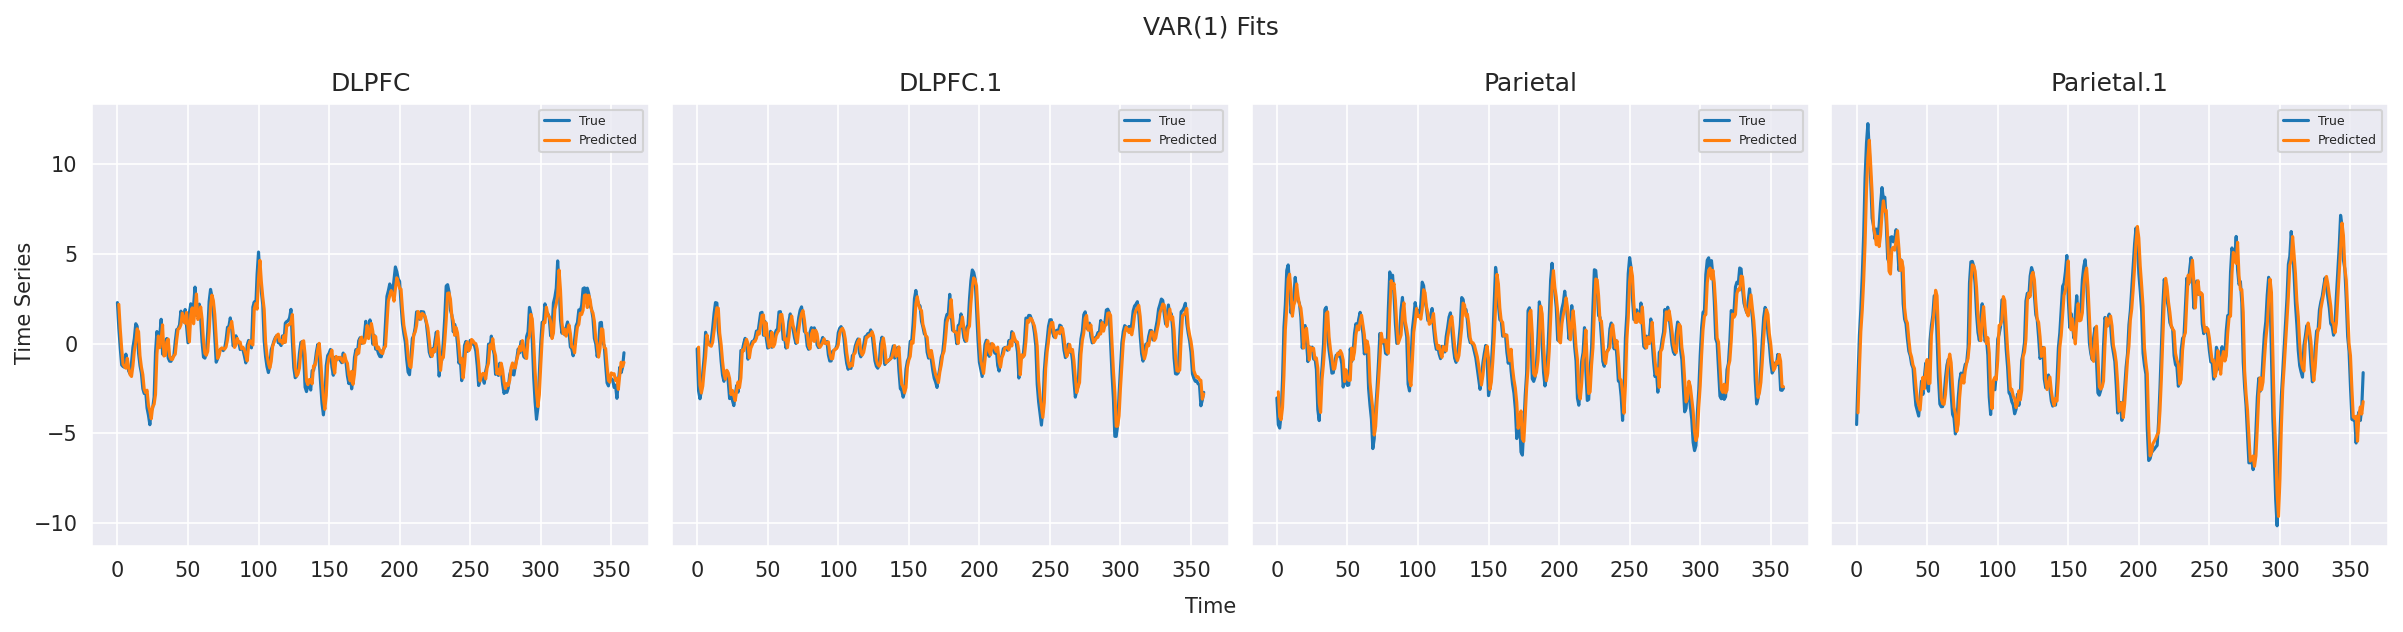

In [75]:
y = np.array(df.iloc[-1])[None, :]
in_sample = model.predict(result.params)
in_sample = pd.DataFrame(data=in_sample, index=df.index[1:], columns=df.columns)

fig, axes = plt.subplots(nrows=1, ncols=4, sharex="all", sharey="all", figsize=(16, 4))

for i, col in enumerate(df.columns):
    ax = axes[i]
    df[col].plot(ax=ax, label="True")
    in_sample[col].plot(ax=ax, label="Predicted")
    ax.set_title(col)
    ax.legend()

fig.text(0.5, 0.01, "Time", ha="center", va="top")
fig.text(0.01, 0.5, "Time Series", rotation="vertical", va="center", ha="right")
fig.suptitle("VAR(1) Fits")
plt.tight_layout()

## Task 3: AR Poisson Processes

### 1. Create your own second order Poisson time series with the given parameters.

According to equation 7.36 in the script:
$$
\log \bold{\mu}_t = \bold{a}_0 + \sum_{m=1}^{M} \bold{A}_m \bold{c}_{t-m}
$$

With $c_{it} \sim \operatorname{Poisson}(\mu_{it}) \quad \forall i$.

In [76]:
T = 1000
A1 = np.array([
    [0.2, -0.1],
    [0.1, 0.1]
])
A2 = np.array([
    [0.1, -0.1],
    [0.1, 0.1]
])
mu0 = np.array([[0.5, 0.5]]).T
a0 = np.array([[0.0, 0.0]]).T

In [119]:
def poisson_factory(mu, As, a0):
    cs = []
    def poisson(T):
        nonlocal mu
        for t in range(T):
            # sample the last c from the last mu
            try:
                c = scistats.poisson.rvs(mu=mu)
            except ValueError:
                # overflow can happen randomly
                break
            cs.append(c)
            M = min(len(cs), len(As))
            # compute the new mu from the last few cs
            s = [np.matmul(As[m], cs[t-m]) for m in range(M)]
            logmu = a0 + np.sum(s, axis=0)
            mu = np.exp(logmu)

        return np.squeeze(cs)

    return poisson

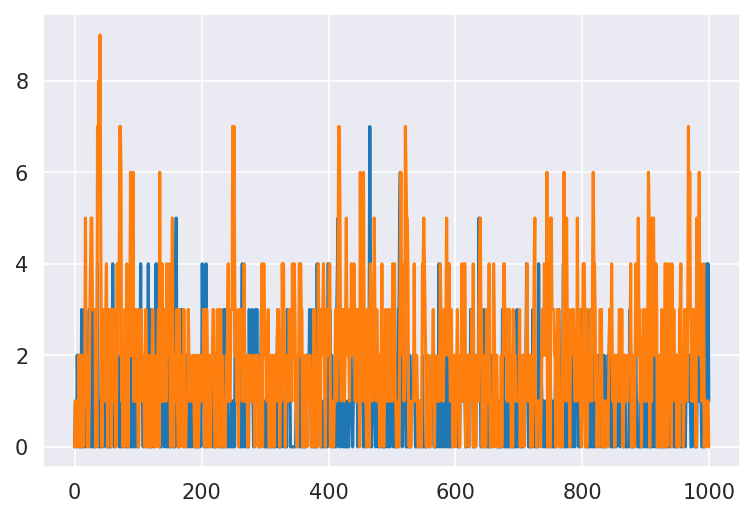

In [120]:
p = poisson_factory(mu0, [A1, A2], a0)

ts = p(T)

plt.plot(ts[:, 0])
plt.plot(ts[:, 1])

### 2. Given the data generated in (1), vary the parameters $A_1(1, 1)$ and $A_2(2, 1)$ between 0 and 0.4 with 0.01 increments. For each parameter value pair, compute the log-likelihood of the data (keeping all other parameters fixed).

In [ ]:
a1s = np.arange(start=0.0, stop=0.41, step=0.01)
a2s = a1s.copy()

lls = np.zeros((len(a1s), len(a2s)))

for i, a1 in enumerate(a1s):
    for j, a2 in enumerate(a2s):
        A1 = np.array([
            [a1, -0.1],
            [0.1, 0.1]
        ])
        A2 = np.array([
            [0.1, -0.1],
            [a2, 0.1]
        ])

        p = poisson_factory(mu0, [A1, A2], a0)

        ts = p(T)

        # compute the log likelihood
        ll = ...

        lls[i, j] = ll

lls

### Plot the log-likelihood landscape surface as a function of these two parameters.

In [ ]:
plt.imshow(lls)

### Does the real parameter pair value correspond (or is close) to an extreme point in the approximate log-likelihood landscape? What kind of extreme point is it?

...